#### Задание 2
Имеются результаты A/B теста, в котором двум группам пользователей предлагались различные наборы акционных предложений. Известно, что ARPU в тестовой группе выше на 5%, чем в контрольной. При этом в контрольной группе 1928 игроков из 202103 оказались платящими, а в тестовой – 1805 из 202667.

Какой набор предложений можно считать лучшим? Какие метрики стоит проанализировать для принятия правильного решения и как?

In [1]:
import pandas as pd
import requests
from urllib.parse import urlencode
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import numpy as np
from scipy.stats import chi2_contingency
import pingouin as pg
from scipy import stats
from scipy.stats import norm
import warnings

warnings.filterwarnings('ignore')

plt.style.use('ggplot')

%matplotlib inline

In [2]:
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
public_key = 'https://disk.yandex.ru/d/SOkIsD5A8xlI7Q' 


final_url = base_url + urlencode(dict(public_key=public_key))
response = requests.get(final_url)
download_url = response.json()['href']


download_response = requests.get(download_url)
data = pd.read_csv(download_url, sep=';')
data.head()  #получаем данные

,user_id,revenue,testgroup
0,1,0,b
1,2,0,a
2,3,0,a
3,4,0,b
4,5,0,b


In [3]:
data.shape

(404770, 3)

In [4]:
data.user_id.nunique()

404770

In [5]:
data.revenue.nunique()  # такое небольшое кол-во уникальных значений свидетельствует о большом кол-ве повторов.

1477

In [6]:
data.testgroup.nunique()

2

In [7]:
data.dtypes

user_id       int64
revenue       int64
testgroup    object
dtype: object

In [8]:
data.testgroup = data.testgroup.astype('str')  # конвертируем колонку testgroup в корректный формат

In [9]:
data.isnull().sum()  # пропусков нет

user_id      0
revenue      0
testgroup    0
dtype: int64

In [10]:
data.query('testgroup == "a"').shape

(202103, 3)

In [11]:
data.query('testgroup == "b"').shape

(202667, 3)

Для начала надо проверить корректность выборок, затем - сравнить их корректным тестом и проверить, есть ли статистическая значимость у этих 5%.
1. Нулевая гипотеза: Оба набора предложений имеют одинаковые значения показателя платежной активности пользователей.

2. Альтернативная гипотеза: Наборы имеют разные значения показателя платежной активности пользователей. Между наборами есть статистически значимая разница.

In [12]:
data.groupby('user_id', as_index=False).agg({'revenue': 'count'}).sort_values('revenue', ascending=False).head()
# для начала проверим, есть ли в данных дубликаты, т.е. юзеры, попавшие в обе группы. Таковых нет

,user_id,revenue
0,1,1
269854,269855,1
269852,269853,1
269851,269852,1
269850,269851,1


In [13]:
data.groupby('testgroup').agg({'user_id': 'count'})  # Выборки примерно равны

,user_id
testgroup,
a,202103
b,202667


С помощью критерия Хи-квадрат проверим, значимы ли различия между группами в количестве платящих пользователей.
Н0 - различий нет, Н1 - различия есть.

In [14]:
a_pay = data.query('testgroup=="a" & revenue>0').shape[0]
a_all = data.query('testgroup=="a"').shape[0]
b_pay = data.query('testgroup=="b" & revenue>0').shape[0]
b_all = data.query('testgroup=="b"').shape[0]

In [15]:
payment_data = np.array([[a_pay, a_all], [b_pay, b_all]])
pay = chi2_contingency(payment_data)
pay_a = a_pay / a_all * 100
pay_b = b_pay / b_all * 100
print(f'chisq-statistic={round(pay[0], 2)}, p-value={round(pay[1], 2)}')
print(f'В контрольной группе платящих пользователей {round(pay_a, 2)}%.')
print(f'В тестовой группе платящих пользователей {round(pay_b, 2)}%.')

chisq-statistic=4.29, p-value=0.04
В контрольной группе платящих пользователей 0.95%.
В тестовой группе платящих пользователей 0.89%.


Поскольку значение p < 0.05, мы отклоняем нулевую гипотезу и делаем вывод, что соотношение платящих/неплатящих пользователей в двух группах различается (в контрольной группе платящих пользователей больше). Это может исказить результаты дальнейших тестов.

Далее посмотрим на распределение платящих пользователей.

Text(0.5, 0, 'b')

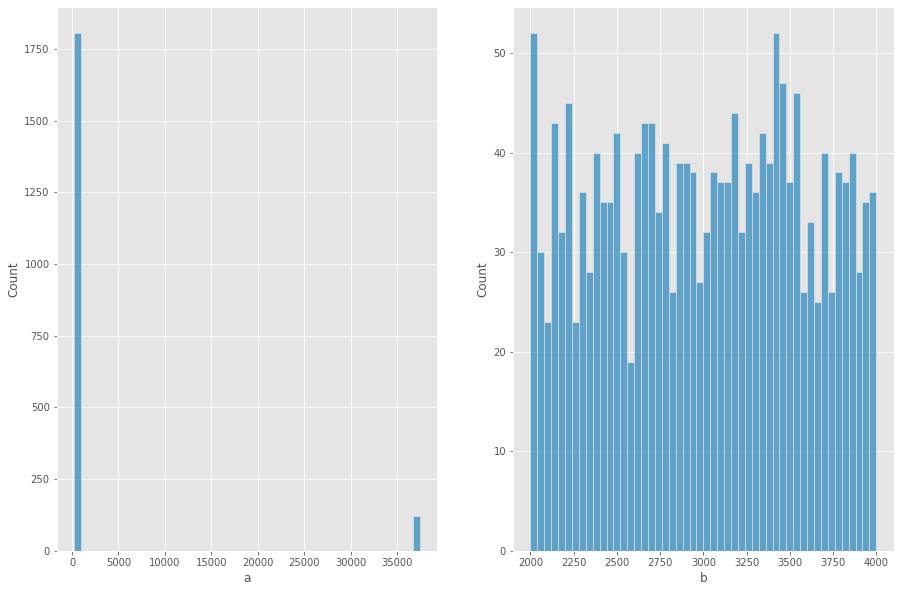

In [16]:
plt.rcParams['figure.figsize'] = (15, 10)

plt.subplot(1, 2, 1)
sns.histplot(data.query('testgroup == "a" & revenue > 0').revenue, bins=50, kde=False)
plt.xlabel('a')

plt.subplot(1, 2, 2)
sns.histplot(data.query('testgroup == "b" & revenue > 0').revenue, bins=50, kde=False)
plt.xlabel('b')

В контрольной группе наблюдается сильно неравномерное распределение данных. У части пользователей очень высокие платёжные показатели. Возможно, это выброс. К этой проблеме мы вернёмся позже, а пока проведём стандартный анализ.

Для большей уверенности проведём тест на нормальность.

In [17]:
pg.normality(data=data, dv="revenue", group="testgroup", method="normaltest") 

,W,pval,normal
b,326622.395409,0.0,False
a,585152.731273,0.0,False


Распределение в обеих выборках отлично от нормального. Согласно классическим учебникам статистики, а также конкретно этому курсу, использование параметрических тестов может привести к ошибочному результату (о чём прямо говориться в одной из лекций). 
Однако ряд учёных-статистиков считают, что на больших выборках можно пренебречь требованием нормальности. Впрочем, согласны с ними далеко не все, и другие учёные-статистики считают, что классические параметрические тесты и вовсе являются пережитком тех времён, когда у статистиков не было вычислительных мощностей, и приходилось аппроксимировать к понятию нормального распределения, и что в нынешнее время лучше использовать такие методы, как бутстрап и метод перестановки.
Поэтому, чтобы не вдаваться в споры о том, какой метод лучше, стоит провести все тесты. НО! Чрезмерное количество тестов может привести к появлению ошибки первого рода, поэтому при многократном тестировании стоит понизить порог альфы. Например, применить поправку Бонферрони.

In [18]:
sample1 = data.query('testgroup == "a"')
sample2 = data.query('testgroup == "b"')
pg.ttest(sample1.revenue, sample2.revenue)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-0.623488,240991.130782,two-sided,0.532965,"[-5.54, 2.87]",0.001962,0.004,0.095694


t-test однозначно не позволяет отклонить H0, так что даже не приходится применять поправки. Возможно, виной всему всё-таки выбросы и слишком разная форма распределений в группах. Поскольку сама возможность применения этого теста в данной ситуации спорная, то однозначно полагаться на его результаты нельзя.

Используем критерий Манна-Уитни, более устойчивый к выбросам, чем параметрические критерии. Но сначала посчитаем количество повторяющихся значений.

In [19]:
data.revenue.value_counts()[0:20]

0      401037
206        18
310        18
265        17
224        17
397        17
357        16
396        15
315        15
334        15
221        15
273        14
320        14
388        14
344        14
345        14
246        13
215        13
269        13
238        13
Name: revenue, dtype: int64

К сожалению, в выборке слишком много повторяющихся значений. Результат теста может быть искажён.

In [20]:
p_value = round(stats.mannwhitneyu(data.query('testgroup == "a"').revenue, data.query('testgroup == "b"').revenue)[1], 3)
if p_value < 0.05:
    print(f'Тест выявил различия, отклоняем Н0. p-value: {p_value}')
else:
    print(f'Результаты теста не позволяют нам отклонить Н0. p-value: {p_value}')

Результаты теста не позволяют нам отклонить Н0. p-value: 0.063


Тест Манна-Уитни не позволяет нам отвергнуть нулевую гипотезу о том, что оба набора предложений имеют одинаковые значения показателя платежной активности пользователей. Однако, как сказано выше, результат теста может быть искажён из-за большого кол-ва повторов, и поэтому он не позволяет сделать однозначный вывод.

Далее рассчитаем ARPU.

In [21]:
ARPU_a = data.query('testgroup == "a"').revenue.mean().round(2)
ARPU_b = data.query('testgroup == "b"').revenue.mean().round(2)
ARPU_diff = round((ARPU_b - ARPU_a) / ARPU_a * 100, 2)

print(f'ARPU_a = {ARPU_a}\nARPU_b = {ARPU_b} \nARPU_diff = {ARPU_diff}%')

ARPU_a = 25.41
ARPU_b = 26.75 
ARPU_diff = 5.27%


Рассчитаем ARPPU, который учитывает только платящих пользователей.

In [22]:
ARPPU_a = data.query('testgroup == "a" & revenue > 0').revenue.mean().round(2)
ARPPU_b = data.query('testgroup == "b" & revenue > 0').revenue.mean().round(2)
ARPPU_diff = round((ARPPU_b - ARPPU_a) / ARPPU_a * 100, 2)

print(f'ARPPU_a = {ARPPU_a}\nARPPU_b = {ARPPU_b} \nARPPU_diff = {ARPPU_diff}%')

ARPPU_a = 2664.0
ARPPU_b = 3003.66 
ARPPU_diff = 12.75%


Ситуация с ARPPU сходна с таковой у ARPU, при этом разница ещё выше (почти 13%). Поскольку ARPPU = CR * ARPU, то несложно посчитать конверсию:

In [23]:
CR_a = (ARPPU_a / ARPU_a).round(2)
CR_b = (ARPPU_b / ARPU_b).round(2)
CR_diff = round((CR_b - CR_a) / CR_a * 100, 2)

print(f'CR_a = {CR_a}\nCR_b = {CR_b} \nCR_diff = {CR_diff}%')

CR_a = 104.84
CR_b = 112.29 
CR_diff = 7.11%


Конверсия в тестовой группе также выше. Можно сделать предварительный осторожный вывод о том, что различия в данных группах всё-таки есть. Поскольку результату Манн-Уитни доверять нельзя, для большей уверенности необходимо провести дополнительные тесты, дабы не совершить ошибку второго рода, не отклонив нулевую гипотезу при верной альтернативной. Проведем бутстрап-анализ, как "универсальный инструмент", т.к. он позволяет проводить анализ даже в тех случаях, когда для классических критериев не соблюдены условия. Данный метод рядом учёных-статистиков считается одним из наиболее современных и показательных. Тем не менее, у бутстрапа также есть ограничение, а именно ему нужна репрезентативная выборка. Оценить репрезентативность выборок в условиях данного задания невозможно, однако в том случае, если выборки у нас нерепрезентативные, любые результаты будут поставлены под сомнения.

In [24]:
group_a = data.query('testgroup == "a"').revenue
group_b = data.query('testgroup == "b"').revenue

boot = pd.DataFrame({
    "group_a": group_a,
    "group_b": group_b
})

boot = boot.fillna(0)

In [25]:
# Пробуем бутстрап-анализ

def get_bootstrap(
    data_column_1,  # числовые значения первой выборки
    data_column_2,  # числовые значения второй выборки
    boot_it=1000,  # количество бутстрэп-подвыборок
    statistic=np.median,  # интересующая нас статистика
    bootstrap_conf_level=0.95  # уровень значимости
):
    boot_data = []
    for i in tqdm(range(boot_it)):  # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            len(data_column_1), 
            replace=True  # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            len(data_column_1), 
            replace=True
        ).values
        
        boot_data.append(statistic(samples_1) - statistic(samples_2))  # применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level) / 2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x=0, 
        loc=np.mean(boot_data), 
        scale=np.std(boot_data)
    )
    p_2 = norm.cdf(
        x=0, 
        loc=-np.mean(boot_data), 
        scale=np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
    
        # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins=50)
    for bar in bars:
        if bar.get_x() <= quants.iloc[0][0] or bar.get_x() >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants, ymin=0, ymax=50, linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "quants": quants, 
            "p_value": p_value}

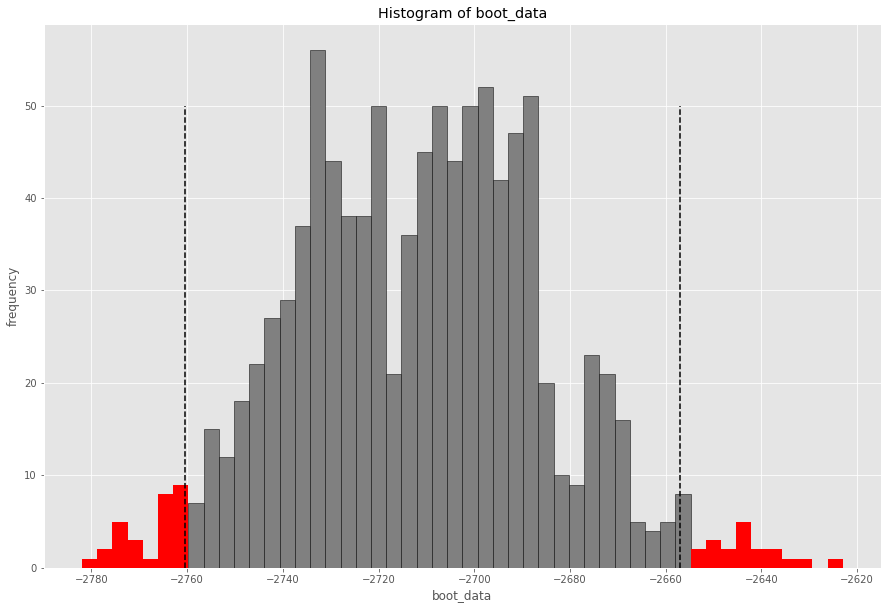

In [26]:
booted_data_median = get_bootstrap(boot.query('group_a != 0').group_a, boot.query('group_b != 0').group_b)

In [27]:
booted_data_median['quants']

,0
0.025,-2760.5125
0.975,-2657.0000


In [28]:
booted_data_median['p_value']

0.0

Границы доверительного интервала не пересекают 0, а p < 0.01. Бутстрап анализ показал, что в данных действительно есть статически значимые различия. Причём альфа не только ниже условного порога 0.05, но и даже ниже 0.01, т.е. даже с учётом поправок результат можно считать достоверным. Теперь мы можем с определённой уверенностью утверждать, что наборы имеют разные значения показателя платежной активности пользователей, и в тестовой группе ARPU значимо увеличился по сравнению с контрольной.

Однако, как было показано в самом начале анализа, в тестовой группе меньше платящих пользователей. Если допустить, что обе выборки (контрольная и тестовая) были составлены корректно и изначально обладали одинаковым % платящих пользователей, то значит, что в контрольной группе платящих пользователей после эксперимента стало меньше. А это говорит не в пользу тестового набора предложений.

Возможно, в разных платёжных сегментах поведение пользователей различается. Иными словами, пользователи, которые платят много, реагируют на предложения иначе, чем пользователи, платящие мало. Самый простой пример: малоплатящие пользователи - это дети, а платящие много - взрослые. Вполне ожидаемо, что они будут по-разному реагировать на разные предложения (например, взрослых меньше будет интересовать дизайн игровых персонажей в стиле Марвел). Возрастное разделение здесь приведено исключительно как пример, реальная разбивка пользователей может быть совсем другой.

Поэтому дальше попробуем разделить пользователей на 2 сегмента по платежеспособности (поскольку в контрольной группе пользователи распадаются именно на 2 категории: менее 400 и выше 35 тыс, а между ними "пустота").

Text(0.5, 0, 'b')

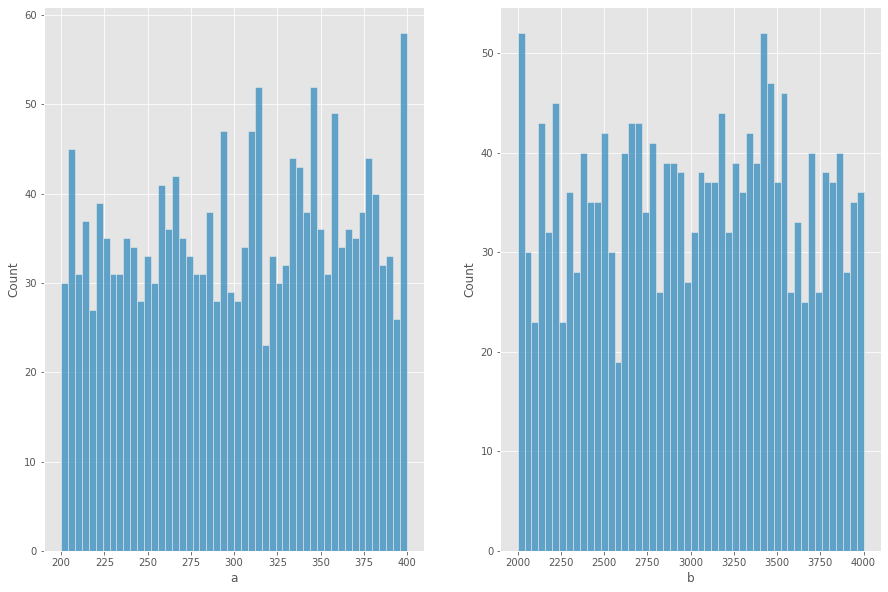

In [29]:
# Распредение в малоплатящем сегменте.

plt.rcParams['figure.figsize'] = (15, 10)

plt.subplot(1, 2, 1)
sns.histplot(data.query('testgroup=="a" & 0<revenue<35000').revenue, bins=50, kde=False)
plt.xlabel('a')

plt.subplot(1, 2, 2)
sns.histplot(data.query('testgroup=="b" & 0<revenue<35000').revenue, bins=50, kde=False)
plt.xlabel('b')

По графикам видно, что в "бюджетном" сегменте размах revenue в контрольной группе 200 - 400, в то время как в тестовой 2000 - 4000, т.е. разница в 10 раз.

Пересчитаем ARPPU для этих групп для большей уверенности.

In [30]:
ARPPU_a_low = data.query('testgroup == "a" & 0 < revenue < 35000').revenue.mean().round(2)
ARPPU_b_low = data.query('testgroup == "b" & 0 < revenue < 35000').revenue.mean().round(2)
ARPPU_diff_low = round((ARPPU_b_low - ARPPU_a_low) / ARPPU_b_low * 100, 2)

print(f'ARPPU_a_low = {ARPPU_a_low}\nARPPU_b_low = {ARPPU_b_low} \nARPPU_diff_low = {ARPPU_diff_low}%')

ARPPU_a_low = 302.46
ARPPU_b_low = 3003.66 
ARPPU_diff_low = 89.93%


Видим колоссальную разницу в ARPPU в "бюджетном" сегменте.

Text(0.5, 0, 'b')

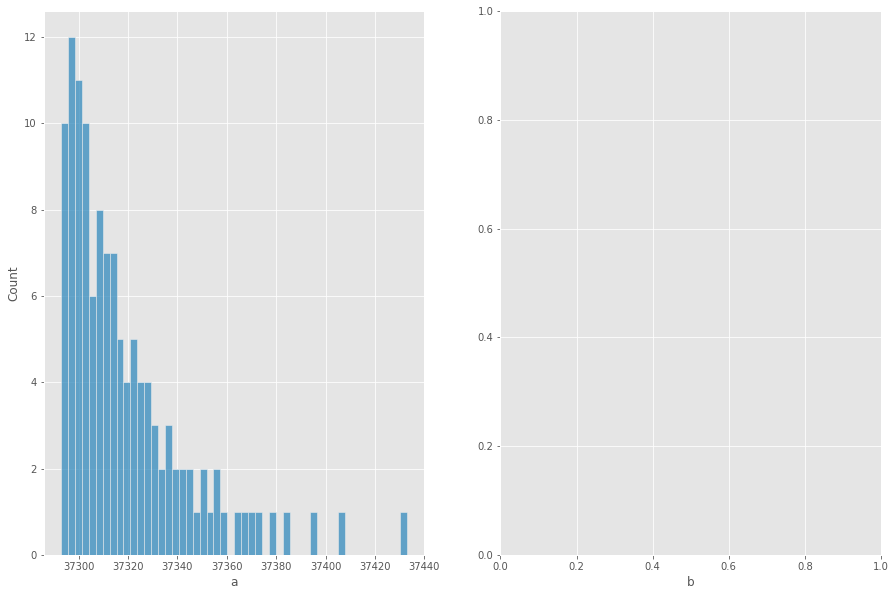

In [31]:
# Распредение в высокоплатящем сегменте.

plt.rcParams['figure.figsize'] = (15, 10)

plt.subplot(1, 2, 1)
sns.histplot(data.query('testgroup=="a" & revenue>=35000').revenue, bins=50, kde=False)
plt.xlabel('a')

plt.subplot(1, 2, 2)
sns.histplot(data.query('testgroup=="b" & revenue>=35000').revenue, bins=50, kde=False)
plt.xlabel('b')

В тестовой группе пусто. Если вернуться к графику выше в самом начале анализа, то мы увидим, что в тестовой группе пользователи ограничены максимальным показателем платёжности в 4000, т.е. "бюджетным" сегментом. ARPPU в "вип"-сегменте тестовой группы отсутствует как таковой, поэтому разницу между группами в этих показателях можно приравнять к 100% в пользу контрольной группы.

In [32]:
ARPPU_a_high = data.query('testgroup == "a" & revenue>35000').revenue.mean().round(2)
ARPPU_b_high = 0
ARPPU_diff_high = round((ARPPU_a_high - ARPPU_b_high) / ARPPU_a_high * 100, 2)

print(f'ARPPU_a_high = {ARPPU_a_high}\nARPPU_b_high = {ARPPU_b_high} \nARPPU_diff_high = {ARPPU_diff_high}%')

ARPPU_a_high = 37319.12
ARPPU_b_high = 0 
ARPPU_diff_high = 100.0%


In [33]:
data.query('testgroup == "a" & revenue>35000').shape[0]  # кол-во вип-игроков

123

In [34]:
a_pay - b_pay  # разница в кол-ве платящих игроков в двух группах

123

Мы видим, что кол-во платящих игроков в контрольной группе меньше, чем в тестовой, на 123 - именно столько игроков составляют "вип"-сегмент в тестовой группе. Если обе выборки изначально были составлены корректно и захватывали все сегменты игроков, то можно предположить, что "вип"-игрокам из контрольной группы настолько не понравился набор предложений В, что они вообще бросили игру, и поэтому не попали в финальную выборку (если учитывать, что в конце эксперимента брались только те игроки, которые на данный момент стабильно заходили в игру, а "мёртвые" не учитывались, даже если они и были изначально в этой выборке).

In [35]:
d1 = {'ARPU': [ARPU_a, ARPU_b, ARPU_diff], 'ARPPU': [ARPPU_a, ARPPU_b, ARPPU_diff], 'CR': [CR_a, CR_b, CR_diff]}
Total_metrics = pd.DataFrame(data=d1, index=['a', 'b', 'difference'])

d2 = {'ARPPU_lowcost': [ARPPU_a_low, ARPPU_b_low, ARPPU_diff_low], 'ARPPU_vip': [ARPPU_a_high, ARPPU_b_high, ARPPU_diff_high]}
Segments_metrics = pd.DataFrame(data=d2, index=['a', 'b', 'difference'])

## Выводы.

<b> Показатели, рассчитанные на всю выборку:</b>

In [36]:
Total_metrics

,ARPU,ARPPU,CR
a,25.41,2664.00,104.84
b,26.75,3003.66,112.29
difference,5.27,12.75,7.11


<b> ARPPU бюджетного и вип-сегментов по-отдельности:</b>

In [37]:
Segments_metrics

,ARPPU_lowcost,ARPPU_vip
a,302.46,37319.12
b,3003.66,0.00
difference,89.93,100.00


<b>1.</b>Общие соображения. Пользователи очень неравномерно распределяются по группам. В контрольной группе мы видим сильный разрыв между бюджетными и платящими пользователями, в то время как в тестовой они сосредоточены "посередине". Оптимальным решением было бы запросить первоначальные выборки и посмотреть, насколько они корректно составлены, поскольку такие неравномерные распределения наталкивают на 2 гипотезы: 1. у нас изначально некорректно составлены выборки и 2. наборы предложений НАСТОЛЬКО сильно различаются, что приводят к таким колоссальным изменениям в тестовой выборке после проведения эксперимента. Тем не менее, поскольку в контрольной группе, по-идее, никаких экспериментов в принципе не проводилось (иначе она бы не была контрольной), то она должна отображать именно то распределение пользователей в обеих группах, которое и было до начала эксперимента. А оно очень неравномерное, что ставит под сомнение репрезентативность выборок. Следуя этим рассуждениям, а также принципу бритвы Оккама, напрашивается вывод, что выборки составлены некорректно. А это значит, что и весь дальнейший АВ тест не имеет смысла.

Если же выборки всё-таки составлены корректно (допустим, мне удалось получить нужные данные и проверить их), выводы будут такими:

<b>2.</b>Показатель ARPU статистически достоверно увеличился на 5% в тестовой группе по сравнению с контрольной.

<b>3.</b>Поведение пользователей принципиально отличается в зависимости от платёжного сегмента, к которому они относятся. Для игроков "бюджетного" сегмента набор В (тестовый) оказался более предпочтительным, в то время как для "вип"-сегмента предпочительнее набор А (контрольный).

<b>4.</b>Если существует технологическая возможность, то стоит оставить оба набора предложений: для основной массы выкатить набор В, но для "вип"-сегмента оставить А. Это принесёт компании максимальную прибыль.

<b>5.</b>Однако, если таковой возможности нет, то лучшим стоит считать всё-таки набор предложений В, т.к. "вип"-игроков мало, и, соответственно они вносят меньший вклад в ARPU, чем "бюджетные" игроки, о чём говорит общее увеличение ARPU на 5% в тестовой группе.